# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

In [5]:
recommender.get_als_recommendations(2375, N=200)

[1106523,
 899624,
 871756,
 1044078,
 844179,
 1022428,
 12262978,
 1000753,
 5569230,
 1003616,
 947858,
 8090537,
 883932,
 1046545,
 1134678,
 850925,
 1059902,
 8090521,
 944534,
 9835223,
 865456,
 1051323,
 1025535,
 832678,
 999779,
 863447,
 973181,
 940023,
 912147,
 12262778,
 1103691,
 1116376,
 841220,
 874972,
 9836106,
 1096573,
 925862,
 9832469,
 850102,
 938138,
 861279,
 965267,
 12301839,
 913026,
 1097458,
 896613,
 1090931,
 923149,
 1022254,
 999714,
 1038663,
 823990,
 9835451,
 8090539,
 935578,
 895166,
 1004390,
 9419769,
 1002850,
 965766,
 888543,
 847790,
 835300,
 1004906,
 902172,
 1081177,
 1029743,
 999270,
 6534077,
 837304,
 851188,
 937292,
 1081262,
 12330376,
 1121360,
 1046919,
 1092885,
 1102207,
 963339,
 1070702,
 1020823,
 995816,
 956599,
 986912,
 1009770,
 880150,
 12731544,
 1136486,
 832442,
 865528,
 12731714,
 1057749,
 1006878,
 1068719,
 1103476,
 903609,
 1119454,
 913278,
 963971,
 952163,
 864279,
 5563693,
 896862,
 972143,
 9637

In [6]:
recommender.get_own_recommendations(2375, N=200)

[948640,
 918046,
 847962,
 907099,
 873980,
 884694,
 10285454,
 1107760,
 7169090,
 979674,
 10308345,
 1069531,
 974766,
 1015474,
 950935,
 847066,
 1102207,
 1020770,
 9521787,
 974265,
 940996,
 8019845,
 5567194,
 12811490,
 1003616,
 973181,
 890719,
 982955,
 9677152,
 998519,
 1072685,
 1131382,
 1021715,
 12263119,
 960791,
 7441873,
 986021,
 956666,
 1038692,
 9677748,
 9297223,
 927030,
 12757653,
 1046919,
 6391532,
 989069,
 1068451,
 951954,
 835300,
 937343,
 1047249,
 13876348,
 1061732,
 981601,
 1121028,
 1087547,
 828393,
 996269,
 951951,
 1036093,
 1023815,
 5570408,
 827667,
 1082454,
 1006878,
 5570048,
 841309,
 1078652,
 1115553,
 1056492,
 1138467,
 1004945,
 947858,
 1092885,
 1121694,
 938138,
 8019916,
 827919,
 984315,
 10341855,
 883932,
 8291322,
 1096794,
 1028938,
 1087618,
 8020166,
 1082185,
 866871,
 930666,
 825994,
 910151,
 823990,
 848029,
 896613,
 12301839,
 1117219,
 1135258,
 869868,
 1046545,
 899624,
 6442594,
 1137775,
 825343,
 104290

In [7]:
recommender.get_similar_items_recommendation(2375, N=200)

[1046545,
 1044078,
 1042907,
 842125,
 15778319,
 1051323,
 999104,
 896613,
 885863,
 1025535,
 863447,
 878996,
 906923,
 871611,
 999714,
 866871,
 828106,
 819978,
 1021522,
 1017072,
 1070702,
 1027090,
 858373,
 12301100,
 899624,
 5567622,
 1045586,
 823721,
 985999,
 1037417,
 9835903,
 1127025,
 1000753,
 992826,
 1130517,
 1015386,
 6633342,
 848029,
 854716,
 5570383,
 1045069,
 916122,
 1103476,
 1080354,
 966619,
 8291322,
 876232,
 12132312,
 8065410,
 1008032,
 954651,
 1092835,
 6979526,
 1105301,
 7168774,
 1002771,
 865456,
 828106,
 1016276,
 1105488,
 1121360,
 825343,
 972931,
 1038998,
 9553065,
 993430,
 8090537,
 882247,
 5568378,
 948650,
 1046488,
 12262778,
 1098435,
 1108844,
 7441191,
 969945,
 10149303,
 1008799,
 1133312,
 1005576,
 999270,
 844179,
 999858,
 12132277,
 991761,
 8090565,
 9677149,
 909811,
 885309,
 865456,
 896804,
 12757425,
 987615,
 1011736,
 1044759,
 1130458,
 9858920,
 999270,
 885863,
 1087755,
 868909,
 959316,
 1089954,
 109679

In [8]:
recommender.get_similar_users_recommendation(2375, N=200)

[974265,
 1102003,
 9245108,
 5574377,
 1120190,
 10457044,
 879008,
 12427353,
 1101502,
 820612,
 9677454,
 1103513,
 5578856,
 1015539,
 959455,
 949257,
 1012801,
 1129805,
 8090542,
 979674,
 994577,
 875089,
 871514,
 939860,
 1065259,
 1107760,
 10284929,
 948225,
 995502,
 965956,
 945909,
 5574358,
 963686,
 847434,
 1012801,
 6979437,
 882826,
 896757,
 9553048,
 1010308,
 997025,
 5567325,
 5568758,
 1134296,
 820582,
 855454,
 874563,
 948239,
 977559,
 6391134,
 1124971,
 965772,
 873715,
 9926758,
 852015,
 1118120,
 873044,
 1071196,
 881391,
 979674,
 830686,
 1131625,
 1115069,
 942045,
 1038745,
 911614,
 12523928,
 878715,
 918638,
 1053022,
 6391089,
 1131169,
 950894,
 1072392,
 847962,
 875392,
 1115069,
 1120190,
 894360,
 6391557,
 917033,
 853124,
 902640,
 868645,
 9419422,
 13213202,
 834516,
 12263857,
 1117219,
 12523928,
 1131625,
 977927,
 1098719,
 941515,
 997987,
 866548,
 10149656,
 9553335,
 1081533,
 1020208,
 1117219,
 918046,
 871514,
 911974,
 11

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 200 кандидатов (k=200)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


**Решение**

In [9]:
pd.set_option('display.max_columns', None)

Составим список июзеров на трейне

In [10]:
train_users = data_train_lvl_1['user_id'].unique() 

In [11]:
train_users.shape[0]

2495

Начнем строить модель 1-го уровня

In [12]:
lvl_1_model = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
lvl_1_model = lvl_1_model.loc[lvl_1_model.user_id.isin(train_users)]
lvl_1_model.columns=['user_id', 'actual']
lvl_1_model.tail(2)

,user_id,actual
2152,2499,"[861282, 921744, 1050968, 13842089, 828837, 86..."
2153,2500,"[856455, 902192, 903476, 931672, 936634, 95170..."


Посмотрим, какой результат даст similar_items_recommendation

In [13]:
lvl_1_model['similar_item_recommendations'] = lvl_1_model['user_id'].apply(lambda x: \
                                                                           recommender.get_similar_items_recommendation(x, 200))
lvl_1_model['similar_item_recall'] = lvl_1_model.apply(lambda row:recall_at_k(row['similar_item_recommendations'], \
                                                                              row['actual'], k=200), axis=1)
lvl_1_model['similar_item_recall'].mean()

0.0850644385532148

Посмотрим, какой результат даст als_recommendations

In [14]:
lvl_1_model['als_recommendations'] = lvl_1_model['user_id'].apply(lambda x: recommender.get_als_recommendations(x, 200))
lvl_1_model['als_recall'] = lvl_1_model.apply(lambda row: recall_at_k(row['als_recommendations'], row['actual'], k=200), axis=1)
lvl_1_model['als_recall'].mean()

0.09885230698566302

Посмотрим, какой результат даст own_recommendations

In [15]:
lvl_1_model['own_recommendations'] = lvl_1_model['user_id'].apply(lambda x: recommender.get_own_recommendations(x, 200))
lvl_1_model['own_recall'] = lvl_1_model.apply(lambda row: recall_at_k(row['own_recommendations'], row['actual'], k=200), axis=1)
lvl_1_model['own_recall'].mean()

0.13537278412833242

Максимальный результат дал own_recommendations

Посмотрим, как изменяется recall_at_k при изменении k

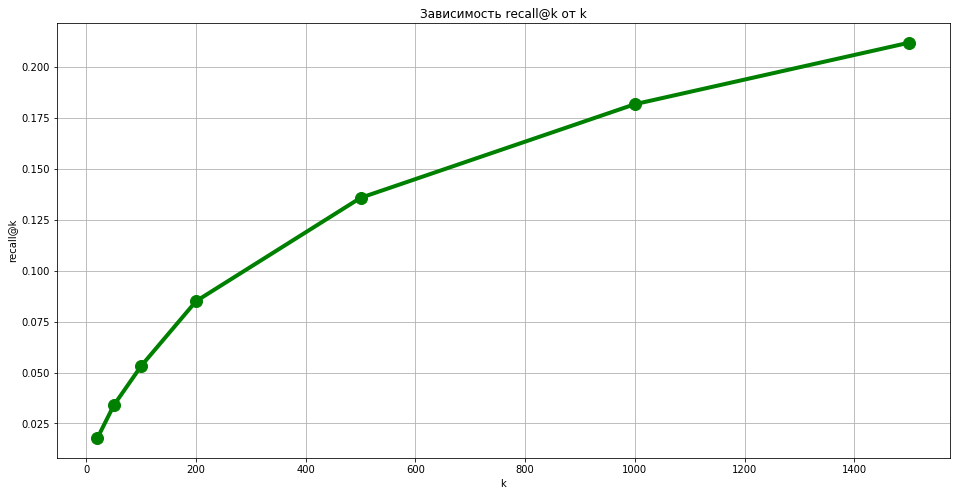

Wall time: 3min 26s


In [16]:
%%time
k = [20, 50, 100, 200, 500, 1000, 1500]
recall_at_k_lst = []

for i in k:
    lvl_1_model[f'similar_items_recs_{i}'] = lvl_1_model['user_id'].apply(lambda x: \
                                                                          recommender.get_similar_items_recommendation(x, N=i))
    rec_at_k = lvl_1_model.apply(lambda row: recall_at_k(row[f'similar_items_recs_{i}'], row['actual'], k=i), axis=1).mean()
    recall_at_k_lst.append(rec_at_k)

plt.rcParams["figure.figsize"] = (16,8)
plt.plot(k, recall_at_k_lst, color='green', marker='o', linewidth=4, markersize=12)
plt.title('Зависимость recall@k от k')
plt.xlabel('k')
plt.ylabel('recall@k')
plt.grid(True)
plt.show()

In [17]:
recall_at_k_lst[-1:]

[0.21202520240788134]

**Вывод:**
    с увеличением k значение recall_at_k увеличивается.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

**Решение**

Посмотрим данные модели первого уровня

In [18]:
# your_code
lvl_1_model.tail(2)

,user_id,actual,similar_item_recommendations,similar_item_recall,als_recommendations,als_recall,own_recommendations,own_recall,similar_items_recs_20,similar_items_recs_50,similar_items_recs_100,similar_items_recs_200,similar_items_recs_500,similar_items_recs_1000,similar_items_recs_1500
2152,2499,"[861282, 921744, 1050968, 13842089, 828837, 86...","[901062, 5569845, 907631, 952563, 1004906, 104...",0.098592,"[907631, 1029743, 5569230, 5568378, 990797, 10...",0.112676,"[7168055, 1128395, 6904613, 5570048, 889989, 8...",0.154930,"[901062, 5569845, 907631, 952563, 1004906, 104...","[901062, 5569845, 907631, 952563, 1004906, 104...","[901062, 5569845, 907631, 952563, 1004906, 104...","[901062, 5569845, 907631, 952563, 1004906, 104...","[901062, 5569845, 907631, 952563, 1004906, 104...","[901062, 5569845, 907631, 952563, 1004906, 104...","[901062, 5569845, 907631, 952563, 1004906, 104..."
2153,2500,"[856455, 902192, 903476, 931672, 936634, 95170...","[9653714, 1034176, 5567874, 823721, 7410168, 8...",0.034091,"[1126899, 1137507, 1114483, 972445, 1110743, 1...",0.022727,"[1063739, 12262832, 1086061, 879393, 1065538, ...",0.079545,"[9653714, 1034176, 5567874, 823721, 7410168, 8...","[9653714, 1034176, 5567874, 823721, 7410168, 8...","[9653714, 1034176, 5567874, 823721, 7410168, 8...","[9653714, 1034176, 5567874, 823721, 7410168, 8...","[9653714, 1034176, 5567874, 823721, 7410168, 8...","[9653714, 1034176, 5567874, 823721, 7410168, 8...","[9653714, 1034176, 5567874, 823721, 7410168, 8..."


Посмотрим данные на втором уровне модели

In [19]:
data_val_lvl_2.tail(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2396802,1167,41656790510,663,6410462,22451,43.98,3385,-0.65,1059,95,0.0,0.0
2396803,1167,41656790510,663,6430664,1,8.00,3385,0.00,1059,95,0.0,0.0


Посмотрим рекомендации ALS

In [20]:
lvl_1_model['als_precision'] = lvl_1_model.apply(lambda row: precision_at_k(row['als_recommendations'], \
                                                                            row['actual'], k=200), axis=1)
als_recommendations = lvl_1_model[['user_id', 'als_recommendations']]
als_recommendations.tail()

,user_id,als_recommendations
2149,2496,"[844179, 899624, 1044078, 1004906, 916122, 806..."
2150,2497,"[899624, 957951, 5569230, 12810391, 963971, 10..."
2151,2498,"[961620, 948086, 830503, 916122, 1097761, 9600..."
2152,2499,"[907631, 1029743, 5569230, 5568378, 990797, 10..."
2153,2500,"[1126899, 1137507, 1114483, 972445, 1110743, 1..."


Посмотрим список фактических айтемов и предлагаемых ALS

In [21]:
valid_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index().rename(columns={'item_id': 'actual'})
valid_lvl_2 = valid_lvl_2.merge(als_recommendations, on='user_id', how='left')
valid_lvl_2.tail(2)

,user_id,actual,als_recommendations
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[907631, 1029743, 5569230, 5568378, 990797, 10..."
2041,2500,"[852182, 856345, 923746, 948670, 1018007, 1044...","[1126899, 1137507, 1114483, 972445, 1110743, 1..."


Посчитаем на валидационных данных precision_at_k рекомендаций, выдаваемых моделью второго уровня. Это будет точность рекомендаций в начальном приближении для отслеживания дальнейшего прогресса.

In [22]:
valid_lvl_2[valid_lvl_2.als_recommendations.notna()].apply(lambda row: \
                                                precision_at_k(row['als_recommendations'], row['actual'], k=5), axis=1).mean()

0.09535248041775418

Добавим фиктивную переменную flag в список юзеров на втором уровне модели

In [23]:
users_lvl_2 = pd.DataFrame(lvl_1_model['user_id'].unique())
users_lvl_2.columns = ['user_id']

train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['recommendations'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, 200))

s = users_lvl_2.apply(lambda x: pd.Series(x['recommendations']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('recommendations', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.tail(2)

,user_id,item_id,flag
2150,2500,8290421,1
2150,2500,923673,1


Скопируем данные модели 1-го уровня в модель 2-го уровня

In [24]:
data_train_lvl_2 = data_val_lvl_1.copy()

In [25]:
data_train_lvl_2.columns

Index(['user_id', 'basket_id', 'day', 'item_id', 'quantity', 'sales_value',
       'store_id', 'retail_disc', 'trans_time', 'week_no', 'coupon_disc',
       'coupon_match_disc'],
      dtype='object')

In [26]:
data_train_lvl_2.to_csv('data_train_lvl_2.csv')

Объединим юзеров и таргеты

In [27]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)
targets_lvl_2.tail(2)

,user_id,item_id,target
436090,2500,8290421,0.0
436091,2500,923673,0.0


In [28]:
targets_lvl_2['target'].mean()

0.04399071755501133

Добавим айтемам цены

In [29]:
price = data.groupby('item_id')['sales_value'].max()
item_features = item_features.merge(price, on='item_id', how='left').rename(columns={'sales_value': 'price'})

Добавим айтемам средние цены

In [30]:
avg_price_by_cat = item_features.groupby('commodity_desc')['price'].mean()
item_features = item_features.merge(avg_price_by_cat, on='commodity_desc', how='left')\
                                                                .rename(columns={'price_x': 'price', 'price_y': 'avg_price'})

Добавим айтемам цены корзины покупок

In [31]:
basket_price = data.groupby('basket_id')['sales_value'].sum()
data = data.merge(basket_price, on='basket_id', how='left').rename(columns={'sales_value_x': 'sales_value', \
                                                                            'sales_value_y': 'basket_price'})
avg_basket_per_user = data.groupby('user_id').basket_price.mean()
user_features = user_features.merge(avg_basket_per_user, on='user_id', how='left')

Добавим фичу "Средняя сумма покупок в неделю". Еще хотелось бы поработать с age_desc (подозреваю, что там есть резерв для роста итоговой точности), но нет времени

In [32]:
x = data.groupby(['user_id', 'week_no']).basket_id.count().reset_index().groupby('user_id').agg(['count', 'sum'])
x.columns = x.columns.droplevel(0)
avg_purchases_per_week = x.iloc[:, 2:].apply(lambda row: row['sum'] / row['count'], axis=1)
avg_purchases_per_week.name = 'avg_purchases_per_week'
user_features = user_features.merge(avg_purchases_per_week, on='user_id', how='left')

In [33]:
user_features.tail(3)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,basket_price,avg_purchases_per_week
798,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown,2497,76.975501,23.925926
799,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498,39.940936,13.883333
800,25-34,U,Under 15K,Unknown,2 Adults Kids,3,1,2499,117.282023,19.775510


Объединим в таргеты для модели 2-го уровня фичи айтемов и фичи юзеров

In [34]:
item_features_tmp = item_features[['item_id',
                                    'manufacturer',
                                    'department',
                                    'brand',
                                    'commodity_desc',
                                    'price',
                                    'avg_price']]

user_features_tmp = user_features[['user_id',
                                    'age_desc',
                                    'income_desc',
                                    'household_size_desc',
                                    'avg_purchases_per_week',
                                    'basket_price']]

targets_lvl_2 = targets_lvl_2.merge(item_features_tmp, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features_tmp, on='user_id', how='left')

targets_lvl_2.tail()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,price,avg_price,age_desc,income_desc,household_size_desc,avg_purchases_per_week,basket_price
436087,2500,991874,0.0,1456,GROCERY,National,EGGS,10.00,3.487479,NaN,NaN,NaN,NaN,NaN
436088,2500,1018740,0.0,3516,DELI,National,DELI MEATS,31.15,7.603926,NaN,NaN,NaN,NaN,NaN
436089,2500,7168890,0.0,151,GROCERY,National,FRZN MEAT/MEAT DINNERS,8.00,5.670097,NaN,NaN,NaN,NaN,NaN
436090,2500,8290421,0.0,2,PRODUCE,National,APPLES,11.56,4.474923,NaN,NaN,NaN,NaN,NaN
436091,2500,923673,0.0,1046,GROCERY,National,COLD CEREAL,8.00,4.661800,NaN,NaN,NaN,NaN,NaN


In [35]:
targets_lvl_2['target'].mean()

0.04399071755501133

Разобъем targets_lvl_2 на тренировочные данные по фичам и по таргету

In [36]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2['target']

In [37]:
X_train.columns

Index(['user_id', 'item_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'price', 'avg_price', 'age_desc', 'income_desc',
       'household_size_desc', 'avg_purchases_per_week', 'basket_price'],
      dtype='object')

In [38]:
cat_columns = ['manufacturer',
               'department',
               'brand',
               'commodity_desc',
               'age_desc',
               'income_desc',
               'household_size_desc']

X_train[cat_columns] = X_train[cat_columns].astype('category')

Создадим LGB-модель (LGBMClassifier()) и выполним ее тренировку

In [39]:
model_lgb = LGBMClassifier(objective='binary', max_depth=3, n_estimators=300, learning_rate=0.01, n_jobs=4, num_leaves=32, \
                           categorical_feature=cat_columns)
model_lgb.fit(X_train, y_train.values)

train_preds = model_lgb.predict_proba(X_train)[:, 1]

d:\Users\Tim\anaconda3\lib\site-packages\lightgbm\basic.py:842: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
d:\Users\Tim\anaconda3\lib\site-packages\lightgbm\basic.py:863: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Посмотрим важность признаков

In [40]:
model_lgb.feature_importances_

array([ 14,  44, 832,   0,   3, 602, 179,  32,   0,   4,   2, 362,  23])

Отобразим диаграмму важности признаков

In [41]:
from lightgbm import plot_importance

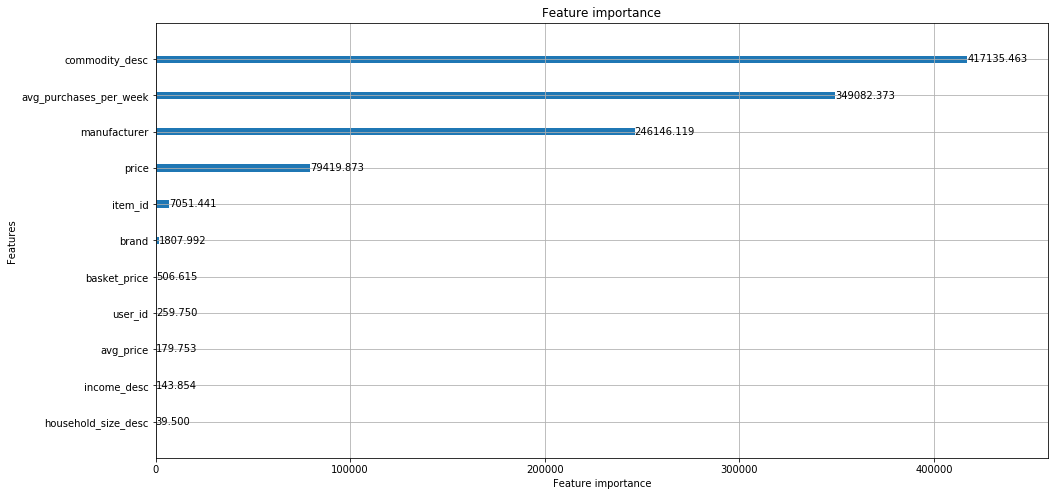

In [42]:
plot_importance(model_lgb, figsize=(16, 8), importance_type='gain')

Посмотрим список рекомендованных для каждого юзера

In [43]:
targets_lvl_2['preds'] = train_preds
targets_lvl_2.sort_values(['user_id', 'preds'], ascending=[True, False], inplace=True)
lgb_recommendations = targets_lvl_2.groupby('user_id').head(5).groupby('user_id')['item_id'].unique().reset_index()
lgb_recommendations.tail()

,user_id,item_id
2146,2496,"[1029743, 1106523, 916122]"
2147,2497,"[1082185, 1029743, 1106523, 933835, 1101010]"
2148,2498,"[916122, 844179, 1004906, 12810393, 892048]"
2149,2499,"[1029743, 1106523, 933835, 1044078, 899624]"
2150,2500,"[1082185, 1126899, 1070820, 916122]"


Посчитаем точность (precision_at_k) полученной модели

In [44]:
valid_lvl_2 = valid_lvl_2.merge(lgb_recommendations, on='user_id', how='left')
valid_lvl_2.rename(columns={'item_id': 'lgb_recommendations'}, inplace=True)
valid_lvl_2[valid_lvl_2.als_recommendations.notna()].apply(lambda row: precision_at_k(row['lgb_recommendations'], \
                                                                                      row['actual'], k=5), axis=1).mean()

0.17026109660574296

**Вывод:**
удалось повысить на валидационных данных precision_at_k с первоначальных 0.095 до 0.17 благодаря добавлению фич и использованию LGB в модели второго уровня

### Финальный проект

Мы уже прошли всю необходимую теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - money precision@5. Порог для уcпешной сдачи проекта money precision@5 > 20%

Бизнес ограничения в топ-5 товарах:
- Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)
- **2 новых товара** (юзер никогда не покупал)
- **1 дорогой товар, > 7 долларов**
- **Все товары из разных категорий** (категория - department)  
- **Стоимость каждого рекомендованного товара > 1 доллара**  

- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и .csv файл с рекомендациями. В .csv файле 2 столбца: user_id - (item_id1, item_id2, ..., item_id5)